In [1]:
import os
os.chdir("./")

import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta 
import matplotlib.pyplot as plt
import yfinance as yf
import talib
from IPython.display import display,Image

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,export_graphviz

from pydotplus import graph_from_dot_data

pd.set_option('display.max_rows',None);

In [2]:
stock_data_list = pd.read_excel("C:/Users/cider/Documents/Python Scripts/data/hk_main_board_cleaned_list.xlsx"); 
stock_ids_arr   = ' '.join(stock_data_list["Stock ID"]);
stock_ids_list  = stock_data_list["Stock ID"].tolist();

# Gary's path: C:/Users/Gary Chu/Documents/Python Scripts_v2/data/hk_main_board_cleaned_list.xlsx
# C:/Users/Administrator/Documents/Python Scripts_2/data/hk_main_board_cleaned_list.xlsx
# C:/Users/cider/Documents/Python Scripts/data/hk_main_board_cleaned_list.xlsx
# Josef's path: C:/Users/josef/Desktop/hk_main_board_cleaned_list.xlsx

In [3]:
# get 10 years data
input_start_date = "2010-01-01";
input_end_date   = "2020-01-01";

In [4]:
# GET Data from yFinance
def getOnlineData_func(start_date,end_date, list_stocks = ""):
    fetch_df = yf.download(list_stocks,start_date,end_date);
    fetch_df = fetch_df[["Open","High","Low","Close","Volume"]];
    return fetch_df;

raw_df = getOnlineData_func(input_start_date,input_end_date, stock_ids_arr);

[*********************100%***********************]  679 of 679 completed

64 Failed downloads:
- 6606.HK: Data doesn't exist for startDate = 1262275200, endDate = 1577808000
- 9983.HK: Data doesn't exist for startDate = 1262275200, endDate = 1577808000
- 6958.HK: Data doesn't exist for startDate = 1262275200, endDate = 1577808000
- 9666.HK: Data doesn't exist for startDate = 1262275200, endDate = 1577808000
- 9677.HK: Data doesn't exist for startDate = 1262275200, endDate = 1577808000
- 2101.HK: Data doesn't exist for startDate = 1262275200, endDate = 1577808000
- 2057.HK: Data doesn't exist for startDate = 1262275200, endDate = 1577808000
- 9618.HK: Data doesn't exist for startDate = 1262275200, endDate = 1577808000
- 1516.HK: Data doesn't exist for startDate = 1262275200, endDate = 1577808000
- 9616.HK: Data doesn't exist for startDate = 1262275200, endDate = 1577808000
- 1024.HK: Data doesn't exist for startDate = 1262275200, endDate = 1577808000
- 9996.HK: Data doesn't exist for st

In [84]:
def filterOutDf(start_date,end_date,good_stock):

    global stock_ids_list

    stocks_arr = stock_ids_list[:]

    for item in good_stock:
        for stockItem in stocks_arr:
            if (item==stockItem):
                stocks_arr.remove(item)

    df = raw_df.copy()
    df = df.loc[pd.to_datetime(start_date):pd.to_datetime(end_date)]
    df = df.drop(stocks_arr, axis=1, level=1)

    return df

# SETUP Filtering Function

In [85]:
def filter_func(start_date,end_date,input_end_date, trace=True):

    final_result_list  = [];
    take_out_list      = [];
    decision_data_list = [];

    final_decision_df  = pd.DataFrame();
    

    df = raw_df.copy();
    df = df.loc[pd.to_datetime(start_date):pd.to_datetime(end_date)];
    df = df[["Close","Volume"]];


    ####### 1.Determine the if the stock is cent stock (< $1) + The 50-days moving average volume < 25,000
    cent_stock_arr = df["Close"].mean() <1;
    take_out_list = cent_stock_arr.index[cent_stock_arr].tolist();

    for item in df["Volume"]:
        vol_sma50item_df = df["Volume"][item].rolling(window=50).mean();
        if(vol_sma50item_df.iloc[-1]<25000):
            take_out_list.append(item)

    df = df.drop(take_out_list, axis=1, level=1)



    ####### 2.filterd by SMA (e.g 20,50,150,200 SMA) are with positive slope
    good_stock = []

    for item in df["Close"]:
        
        latest_volume = df["Volume"][item].iloc[-1]
        latest_price = df["Close"][item].iloc[-1]

        volume_diff = 0;

        if (latest_volume>0):
            volume_diff = (latest_volume - df["Volume"][item].iloc[-2])/latest_volume;
            
        
        sma10_df  = df["Close"][item].rolling(window=10).mean();
        sma20_df  = df["Close"][item].rolling(window=20).mean();
        sma50_df  = df["Close"][item].rolling(window=50).mean();
        sma150_df = df["Close"][item].rolling(window=150).mean();
        sma200_df = df["Close"][item].rolling(window=200).mean();
        
        check_10  = sma10_df.iloc[-1]  - sma10_df.iloc[-2]
        check_20  = sma20_df.iloc[-1]  - sma20_df.iloc[-2]
        check_50  = sma50_df.iloc[-1]  - sma50_df.iloc[-2]
        check_150 = sma150_df.iloc[-1] - sma150_df.iloc[-2]
        check_200 = sma200_df.iloc[-1] - sma200_df.iloc[-2]
        
        sma_good_close = (latest_price       - sma10_df.iloc[-1])/latest_price
        sma_good_10    = (sma10_df.iloc[-1]  - sma20_df.iloc[-1])/latest_price
        sma_good_20    = (sma20_df.iloc[-1]  - sma50_df.iloc[-1])/latest_price
        sma_good_50    = (sma50_df.iloc[-1]  - sma150_df.iloc[-1])/latest_price
        sma_good_150   = (sma150_df.iloc[-1] - sma200_df.iloc[-1])/latest_price
        
        check_10_20_gap = (sma10_df.iloc[-1]-sma20_df.iloc[-1])/sma20_df.iloc[-1]
        check_20_50_gap = (sma20_df.iloc[-1]-sma50_df.iloc[-1])/sma50_df.iloc[-1]
        
        if check_10>0 and check_20>0 and check_50>0 and check_150>0 and check_200>0 and sma_good_close>=0.01 and sma_good_close<=0.13 and sma_good_10>0 and sma_good_20>0 and sma_good_20<0.056 and sma_good_50>0 and sma_good_150>0.027 and sma_good_150<=0.044 and check_10_20_gap>0 and check_20_50_gap>0 and volume_diff>0:
            good_stock.append(item)

    ####### 3. filter by Relative Strength Index (RSI)
    if len(good_stock)>0 :
        
        #rsi_standard = 88

        df = filterOutDf(start_date,end_date,good_stock)

        for item in df["Close"]:
            rsi_value = talib.RSI(df["Close"][item]).iloc[-1]
            if(rsi_value>=59.941 and rsi_value<=79.219):
#                 and rsi_value<=79.219
                final_result_list.append(item)

        #generate final data-->back test
        if len(final_result_list)>0 :
            
            df = filterOutDf(start_date,end_date,final_result_list)
            
            columns_name = ["Stock ID", "price_diff_sma10", "sma10_diff_sma20","sma20_diff_sma50","sma50_diff_sma150","sma150_diff_sma200","RSI","volume_diff","Result"];
            
            #for decision tree df
            for item in df["Close"]:

                latest_volume = df["Volume"][item].iloc[-1]
                latest_price = df["Close"][item].iloc[-1]

                rsi_value = talib.RSI(df["Close"][item]).iloc[-1]
                
                sma10_df  = df["Close"][item].rolling(window=10).mean();
                sma20_df  = df["Close"][item].rolling(window=20).mean();
                sma50_df  = df["Close"][item].rolling(window=50).mean();
                sma150_df = df["Close"][item].rolling(window=150).mean();
                sma200_df = df["Close"][item].rolling(window=200).mean();

                volume_diff = 0;
        
                if (latest_volume>0):
                    volume_diff = (latest_volume - df["Volume"][item].iloc[-2])/latest_volume;
                
                price_diff_sma10   = (latest_price       - sma10_df.iloc[-1])/latest_price;
                sma10_diff_sma20   = (sma10_df.iloc[-1]  - sma20_df.iloc[-1])/latest_price;
                sma20_diff_sma50   = (sma20_df.iloc[-1]  - sma50_df.iloc[-1])/latest_price;
                sma50_diff_sma150  = (sma50_df.iloc[-1]  - sma150_df.iloc[-1])/latest_price;
                sma150_diff_sma200 = (sma150_df.iloc[-1] - sma200_df.iloc[-1])/latest_price;

                decision_data_list.append((item,price_diff_sma10,sma10_diff_sma20,sma20_diff_sma50,sma50_diff_sma150,sma150_diff_sma200,rsi_value,volume_diff,"-"))

            final_decision_df = pd.DataFrame(decision_data_list,columns = columns_name);

            #transform to final df for tradeing
            df = filterOutDf(start_date,input_end_date,final_result_list)
        else:
            df = pd.DataFrame();

        
    print("FILTER STOCKS FROM-",start_date,"~",str(end_date).replace("00:00:00", "")," : ",final_result_list);

    return {"final_list":final_result_list,"dataframe":df,"decision_dataframe":final_decision_df};

# SETUP BACKTEST FUNCTION

In [86]:
#Set up report DataFrame
total_profit = 0
final_report_df = pd.DataFrame()
final_profit_df = pd.DataFrame()
final_decision_df = pd.DataFrame()

report_column_names = ["Stock ID", "Buy in date", "Exit date","Buy-in price","Exit price","Profit%","Status","Win"]
profit_column_names = ["Period", "Number of Stocks", "Trade Profit%","Status"]

In [87]:
def backtest_func(start_date, end_date ,total_end_date, trace=True):

    global final_report_df
    global total_profit
    global final_profit_df
    global final_decision_df
    global report_column_names
    global profit_column_names

    result_obj = filter_func(start_date,end_date,total_end_date, trace)
    
    result_list = result_obj["final_list"]
    
    # display(result_obj["decision_dataframe"])

    df          = result_obj["dataframe"].copy()
    dt_df       = result_obj["decision_dataframe"].copy()
    
    buy_in_start_date = pd.to_datetime(end_date) + timedelta(days=1)    # buy in from end_date + 1 days
    buy_in_end_date   = pd.to_datetime(end_date) + timedelta(days=60)   # buy in to end_date   + 60 days

    df = df.loc[buy_in_start_date:buy_in_end_date]

    ######START the back test##########################################
    take_profit_point = 0.20        # 20% profit
    stop_loss         = 0.08        # 8% stop_loss
    dynamic_stop_loss = 0.06        # 6% dynamic stop_loss
    budget_buy        = 10000       # Assume $10000 to buy each stock

    total_stock       = len(result_list)
    report_data_list  = []
    profit_data_list  = []

    total_weighted_average = 0
    profit_return          = 0
    total_budget           = total_stock*budget_buy


    canGetData = True

    if(len(result_list)>0):

        try:
            df.loc[[buy_in_start_date]]
        except:
            canGetData = False
            print("### No Data at this buying date: ",buy_in_start_date," ###")


        if canGetData==True:
            for item in result_list:

                check_trading_now = False

                # Check stock still in trading period [Buy_in_start_date witin buying period]
                if(len(final_report_df)>0):
                    get_same_stock_record_df = final_report_df.loc[final_report_df["Stock ID"] == item];
                    if(len(get_same_stock_record_df)>0):
                        for start, end in zip(get_same_stock_record_df.iloc[:, 1], get_same_stock_record_df.iloc[:, 2]):
                            cal_start = pd.to_datetime(start)
                            cal_end   = pd.to_datetime(end)
                            cal_check = pd.to_datetime(buy_in_start_date)

                            if(cal_start<=cal_check<cal_end):
                                check_trading_now = True
                                # print("SKIP trading:",cal_check,"-stock:",item)
                                


                buy_in_price            = df.loc[[buy_in_start_date]]["Open"][item].values[0]
                target_profit_price     = buy_in_price*(1+take_profit_point)
                target_stop_loss_price  = buy_in_price*(1-stop_loss)

                dynamic_stop_loss_price = target_stop_loss_price
                max_price_now           = buy_in_price

                if(trace):
                    print("Buy in price           [",item,"]:",buy_in_price)
                    print("tagart Profit price    [",item,"]:",target_profit_price)
                    print("tagart Stop Loss price [",item,"]:",target_stop_loss_price)

                #START Trading  $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

                start_trade = True

                if (check_trading_now==False):
                    for i, (index,data) in enumerate(df["Close"].iterrows()):

                        price = data[item]

                        if(start_trade):

                            status = ""
                            win    = "False"

                            #END trading * meet these 3 conditions
                            if(price<=target_stop_loss_price or price<=dynamic_stop_loss_price or price>=target_profit_price):
                                start_trade = False
                                max_price_now = price
                                profit = np.round((max_price_now-buy_in_price)/buy_in_price*100,1)
                                profit_return += ((max_price_now-buy_in_price)/buy_in_price)*(budget_buy)


                            #END trading - stop loss / dynamic loss / dynamic win
                            if(price<=dynamic_stop_loss_price):
                                
                                if(max_price_now>=buy_in_price):
                                    status = "WIN  - dynamic"
                                    win = "True"
                                elif (dynamic_stop_loss_price==target_stop_loss_price):
                                    status = "LOSS"
                                else:
                                    status = "LOSS - dynamic"


                            #END trading - Meet target profit price
                            if(price>=target_profit_price):
                                status = "WIN"
                                win = "True"
                                

                            #END trading - cannot meet anything within period
                            if (i == len(df["Close"]) - 1):
                                start_trade = False
                                max_price_now = price
                                profit = np.round((max_price_now-buy_in_price)/buy_in_price*100,1)
                                profit_return += ((max_price_now-buy_in_price)/buy_in_price)*(budget_buy)
                                
                                status = "LOSS - LIMIT"
                                if(profit>0):
                                    status = "WIN - LIMIT"
                                    win = "True"


                            #Still trading loop - price > max_price_now
                            if (price>max_price_now and start_trade):

                                # set new dynamic stop loss price if precent up > dynamic_stop_loss
                                if( ((price - max_price_now)/max_price_now) >dynamic_stop_loss ):

                                    dynamic_stop_loss_price = max(price*(1-dynamic_stop_loss),target_stop_loss_price)
                                    if trace: print("PROFIT now - new lose pt:",dynamic_stop_loss_price);

                                max_price_now = price


                            if(start_trade==False):
                                #mark final result at decision tree dataframe data
                                dt_df.loc[dt_df['Stock ID'] == item, ['Result']] = win
                                report_data_list.append((item,buy_in_start_date,index,buy_in_price,max_price_now,profit,status,win))
                    
                    if trace: print("-------------------END Trading-----------------")
    
    #END Trading  $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




    #Final Report setting ############################################################################################
    period = str(buy_in_start_date).replace("00:00:00", "") + " - " + str(buy_in_end_date).replace("00:00:00", "")
    
    report_df = pd.DataFrame(report_data_list,columns=report_column_names)


    if(len(result_list)>0 and canGetData==True and check_trading_now==False):

        total_weighted_average = np.round(profit_return/total_budget*100,2)
        profit_df = pd.DataFrame([(period,total_stock,total_weighted_average,"LOSS" if total_weighted_average < 0 else "WIN")],columns=profit_column_names)
        total_profit   += profit
        final_decision_df = pd.concat([final_decision_df,dt_df])
    else:
        #cannot filter any stock this period
        profit_df = pd.DataFrame([(period,0,0,"-")],columns=profit_column_names)
        total_profit   += 0


    #concat all result
    final_report_df = pd.concat([final_report_df,report_df])
    final_profit_df = pd.concat([final_profit_df,profit_df])
    
    
    return {"report_df":report_data_list,"profit":total_weighted_average}
    

In [88]:
def START_BACK_TESTING(start_date ,end_date ,between ,repeat_time, trace=False):

    global final_report_df
    global total_profit
    global final_profit_df
    global final_decision_df

    #reset all global report
    total_profit      = 0
    final_report_df   = pd.DataFrame()
    final_profit_df   = pd.DataFrame()
    final_decision_df = pd.DataFrame()
    
    dates_list = []

    buy_in_end_date = end_date

    for i in range(repeat_time):
        # buy in to end_date + between days
        if i==0:
            buy_in_end_date   = buy_in_end_date
        else:
            buy_in_end_date   = pd.to_datetime(buy_in_end_date) + timedelta(days=between)  
        dates_list.append([start_date,buy_in_end_date])

    for item in dates_list:
        report_data_list = backtest_func(item[0],item[1],input_end_date,trace)
        
    display(final_report_df)
    display(final_profit_df)
    display(final_decision_df)

    winNumber = len(final_report_df[final_report_df['Win'].str.contains("True")])
    nanNumber = len(final_report_df[final_report_df['Win'].str.contains("-")])
    totalNunmber = len(final_report_df['Win']) - nanNumber

    if totalNunmber>0:
        print("---- WIN % ---- ", np.round(winNumber/totalNunmber*100,2),"%")
    print("---- TOTAL OF TRADE PROFIT% ---- ", np.round(final_profit_df["Trade Profit%"].sum(),2),"%")

In [89]:
START_BACK_TESTING("2013-01-01"," 2018-01-01",2,300)

FILTER STOCKS FROM- 2013-01-01 ~  2018-01-01  :  ['1299.HK', '1910.HK', '2669.HK']
FILTER STOCKS FROM- 2013-01-01 ~ 2018-01-03   :  ['0288.HK', '0669.HK', '0823.HK', '1044.HK', '1316.HK', '1686.HK', '2313.HK', '2388.HK']
FILTER STOCKS FROM- 2013-01-01 ~ 2018-01-05   :  ['0813.HK', '1113.HK', '1317.HK', '2669.HK', '3377.HK']
### No Data at this buying date:  2018-01-06 00:00:00  ###
FILTER STOCKS FROM- 2013-01-01 ~ 2018-01-07   :  ['0813.HK', '1113.HK', '1317.HK', '2669.HK', '3377.HK']
FILTER STOCKS FROM- 2013-01-01 ~ 2018-01-09   :  ['0268.HK', '0823.HK', '1093.HK', '1398.HK', '1530.HK', '1686.HK']
FILTER STOCKS FROM- 2013-01-01 ~ 2018-01-11   :  ['1093.HK', '1234.HK', '1317.HK', '1530.HK', '1686.HK', '2388.HK']
FILTER STOCKS FROM- 2013-01-01 ~ 2018-01-13   :  ['0268.HK', '0934.HK', '1093.HK', '1398.HK', '1530.HK', '2669.HK']
### No Data at this buying date:  2018-01-14 00:00:00  ###
FILTER STOCKS FROM- 2013-01-01 ~ 2018-01-15   :  ['0005.HK', '1398.HK', '1686.HK', '2313.HK']
FILTER ST

Stock ID Buy in date  Exit date  Buy-in price  Exit price  Profit%  \
0  1299.HK  2018-01-02 2018-02-06     66.949997   61.000000     -8.9   
1  1910.HK  2018-01-02 2018-01-26     36.900002   33.900002     -8.1   
2  2669.HK  2018-01-02 2018-01-23      2.110000    2.570000     21.8   
0  0288.HK  2018-01-04 2018-03-02      9.260000    9.480000      2.4   
1  0669.HK  2018-01-04 2018-02-06     52.200001   46.200001    -11.5   
2  0823.HK  2018-01-04 2018-02-02     74.000000   68.000000     -8.1   
3  1044.HK  2018-01-04 2018-01-15     87.500000   79.349998     -9.3   
4  1316.HK  2018-01-04 2018-01-17     19.459999   17.520000    -10.0   
5  1686.HK  2018-01-04 2018-01-23      6.200000    6.440000      3.9   
6  2313.HK  2018-01-04 2018-02-07     78.099998   71.550003     -8.4   
7  2388.HK  2018-01-04 2018-03-02     39.849998   39.299999     -1.4   
0  0813.HK  2018-01-08 2018-01-15     20.850000   20.799999     -0.2   
1  1113.HK  2018-01-08 2018-03-08     70.800003   67.000000     -5.4   
2  1317.HK  2018-01-08 2018-01-15      5.000000    4.590000     -8.2   
3  3377.HK  2018-01-08 2018-02-06      6.480000    5.770000    -11.0   
0  0268.HK  2018-01-10 2018-02-06      4.620000    4.730000      2.4   
1  1093.HK  2018-01-10 2018-01-29      9.520833    8.739583     -8.2   
2  1398.HK  2018-01-10 2018-03-09      6.500000    6.880000      5.8   
3  1530.HK  2018-01-10 2018-01-22     16.700001   15.240000     -8.7   
0  1234.HK  2018-01-12 2018-03-12      7.280000    8.470000     16.3   
0  0005.HK  2018-01-16 2018-03-02     84.300003   77.199997     -8.4   
0  1882.HK  2018-01-18 2018-02-06     24.750000   22.250000    -10.1   
0  0200.HK  2018-01-24 2018-02-06     24.650000   21.799999    -11.6   
1  1128.HK  2018-01-24 2018-01-30     29.299999   26.700001     -8.9   
2  2328.HK  2018-01-24 2018-02-06     11.400000   10.413300     -8.7   
3  2601.HK  2018-01-24 2018-02-07     42.299999   38.250000     -9.6   
4  3918.HK  2018-01-24 2018-03-06      6.420000    7.910000     23.2   
0  0027.HK  2018-01-26 2018-03-26     66.000000   71.699997      8.6   
1  0069.HK  2018-01-26 2018-02-05     19.059999   17.459999     -8.4   
2  1339.HK  2018-01-26 2018-02-09      4.550000    4.030000    -11.4   
0  0392.HK  2018-01-30 2018-02-06     49.099998   43.750000    -10.9   
0  1086.HK  2018-02-01 2018-02-06      4.820000    4.320000    -10.4   
0  3933.HK  2018-02-21 2018-04-20      7.160000    7.990000     11.6   
0  1317.HK  2018-02-27 2018-04-27      5.170000    5.600000      8.3   
0  0268.HK  2018-03-01 2018-03-14      5.580000    6.790000     21.7   
0  1093.HK  2018-03-09 2018-03-23      9.895833   10.937500     10.5   
0  0881.HK  2018-03-13 2018-05-09     20.500000   24.600000     20.0   
1  1128.HK  2018-03-13 2018-05-11     29.299999   29.900000      2.0   
0  1234.HK  2018-03-19 2018-05-17      8.720000   10.140000     16.3   
0  2688.HK  2018-03-21 2018-05-18     65.400002   77.599998     18.7   
0  1083.HK  2018-03-27 2018-05-25      7.000000    7.920000     13.1   
0  1448.HK  2018-03-29 2018-05-25      7.700000    8.600000     11.7   
0  0345.HK  2018-04-12 2018-06-08     21.049999   24.650000     17.1   
0  0200.HK  2018-04-16 2018-06-14     26.100000   25.549999     -2.1   
1  1310.HK  2018-04-16 2018-05-07      9.900000   10.680000      7.9   
0  0631.HK  2018-04-18 2018-06-07      2.450000    3.000000     22.4   
0  0883.HK  2018-04-20 2018-06-15     13.120000   12.940000     -1.4   
0  0151.HK  2018-04-24 2018-06-22      6.820000    7.420000      8.8   
0  0968.HK  2018-04-30 2018-05-08      3.650000    3.350000     -8.2   
0  0683.HK  2018-05-02 2018-06-29     37.849998   37.549999     -0.8   
0  1208.HK  2018-05-04 2018-06-26      5.930000    5.360000     -9.6   
1  3933.HK  2018-05-04 2018-06-19      9.040000    8.150000     -9.8   
0  0384.HK  2018-05-10 2018-06-04     28.799999   35.349998     22.7   
0  0168.HK  2018-05-24 2018-06-26     48.400002   44.500000     -8.1   
1  1234.HK  2018-05-24 2018-07-06     11.1

Period  Number of Stocks  Trade Profit% Status
0  2018-01-02  - 2018-03-02                  3           1.59    WIN
0  2018-01-04  - 2018-03-04                  8          -5.30   LOSS
0  2018-01-06  - 2018-03-06                  0           0.00      -
0  2018-01-08  - 2018-03-08                  5          -4.95   LOSS
0  2018-01-10  - 2018-03-10                  0           0.00      -
0  2018-01-12  - 2018-03-12                  0           0.00      -
0  2018-01-14  - 2018-03-14                  0           0.00      -
0  2018-01-16  - 2018-03-16                  0           0.00      -
0  2018-01-18  - 2018-03-18                  0           0.00      -
0  2018-01-20  - 2018-03-20                  0           0.00      -
0  2018-01-22  - 2018-03-22                  0           0.00      -
0  2018-01-24  - 2018-03-24                  9          -1.72   LOSS
0  2018-01-26  - 2018-03-26                  4          -2.80   LOSS
0  2018-01-28  - 2018-03-28                  0           0.00      -
0  2018-01-30  - 2018-03-30                  0           0.00      -
0  2018-02-01  - 2018-04-01                  3          -3.46   LOSS
0  2018-02-03  - 2018-04-03                  0           0.00      -
0  2018-02-05  - 2018-04-05                  0           0.00      -
0  2018-02-07  - 2018-04-07                  0           0.00      -
0  2018-02-09  - 2018-04-09                  0           0.00      -
0  2018-02-11  - 2018-04-11                  0           0.00      -
0  2018-02-13  - 2018-04-13                  0           0.00      -
0  2018-02-15  - 2018-04-15                  0           0.00      -
0  2018-02-17  - 2018-04-17                  0           0.00      -
0  2018-02-19  - 2018-04-19                  0           0.00      -
0  2018-02-21  - 2018-04-21                  1          11.59    WIN
0  2018-02-23  - 2018-04-23                  0           0.00      -
0  2018-02-25  - 2018-04-25                  0           0.00      -
0  2018-02-27  - 2018-04-27                  0           0.00      -
0  2018-03-01  - 2018-04-29                  1          21.68    WIN
0  2018-03-03  - 2018-05-01                  0           0.00      -
0  2018-03-05  - 2018-05-03                  0           0.00      -
0  2018-03-07  - 2018-05-05                  0           0.00      -
0  2018-03-09  - 2018-05-07                  0           0.00      -
0  2018-03-11  - 2018-05-09                  0           0.00      -
0  2018-03-13  - 2018-05-11                  3           7.35    WIN
0  2018-03-15  - 2018-05-13                  0           0.00      -
0  2018-03-17  - 2018-05-15                  0           0.00      -
0  2018-03-19  - 2018-05-17                  3           5.43    WIN
0  2018-03-21  - 2018-05-19                  2           9.33    WIN
0  2018-03-23  - 2018-05-21                  0           0.00      -
0  2018-03-25  - 2018-05-23                  0           0.00      -
0  2018-03-27  - 2018-05-25                  0           0.00      -
0  2018-03-29  - 2018-05-27                  1          11.69    WIN
0  2018-03-31  - 2018-05-29                  0           0.00      -
0  2018-04-02  - 2018-05-31                  0           0.00      -
0  2018-04-04  - 2018-06-02                  0           0.00      -
0  2018-04-06  - 2018-06-04                  0           0.00      -
0  2018-04-08  - 2018-06-06                  0           0.00      -
0  2018-04-10  - 2018-06-08                  0           0.00      -
0  2018-04-12  - 2018-06-10                  1          17.10    WIN
0  2018-04-14  - 2018-06-12                  0           0.00      -
0  2018-04-16  - 2018-06-14                  2           2.89    WIN
0  2018-04-18  - 2018-06-16                  2          11.22    WIN
0  2018-04-20  - 2018-06-18                  1          -1.37   LOSS
0  2018-04-22  - 2018-06-20                  0           0.00      -
0  2018-04-24  - 2018-06-22                  0           0.00      -
0  2018-04-26  - 201

Stock ID  price_diff_sma10  sma10_diff_sma20  sma20_diff_sma50  \
0  1299.HK          0.045836          0.007164          0.002633   
1  1910.HK          0.012256          0.022493          0.026114   
2  2669.HK          0.040094          0.016745          0.014292   
0  0288.HK          0.042065          0.015815          0.050011   
1  0669.HK          0.060190          0.032190          0.024552   
2  0823.HK          0.024033          0.014494          0.025832   
3  1044.HK          0.016255          0.040379          0.037852   
4  1316.HK          0.037981          0.025130          0.055890   
5  1686.HK          0.045032          0.004968          0.015769   
6  2313.HK          0.062388          0.003466          0.012311   
7  2388.HK          0.010453          0.003086          0.023992   
0  0813.HK          0.124865          0.053538          0.021194   
1  1113.HK          0.019857          0.019071          0.015343   
2  1317.HK          0.082727          0.042222          0.000808   
3  2669.HK          0.089787          0.043191          0.016553   
4  3377.HK          0.123077          0.034694          0.034286   
0  0005.HK          0.013594          0.023687          0.037106   
1  0200.HK          0.032525          0.018081          0.022646   
2  0268.HK          0.052953          0.024338          0.036354   
3  1128.HK          0.123549          0.025341          0.039573   
4  2313.HK          0.039781          0.024270          0.026922   
5  2328.HK          0.043455          0.027687          0.021799   
6  2388.HK          0.012395          0.018111          0.029230   
7  2601.HK          0.062007          0.015293          0.000741   
8  3918.HK          0.023639          0.010420          0.047869   
0  0027.HK          0.023440          0.026522          0.035198   
1  0069.HK          0.047479          0.014023          0.023540   
2  1128.HK          0.085520          0.047359          0.046337   
3  1339.HK          0.044420          0.038731          0.030284   
0  0027.HK          0.044877          0.037121          0.037222   
1  0069.HK          0.058693          0.026583          0.033055   
2  1086.HK          0.042739          0.013693          0.050083   
0  3933.HK          0.029764          0.007093          0.040807   
0  0268.HK          0.067376          0.034574          0.054574   
0  0027.HK          0.044577          0.015360          0.026025   
1  0881.HK          0.021346          0.037644          0.004240   
2  1128.HK          0.061815          0.009760          0.023733   
0  0881.HK          0.034186          0.029535          0.018344   
1  1093.HK          0.061496          0.024963          0.028883   
2  1234.HK          0.053588          0.046007          0.047604   
0  1234.HK          0.066887          0.061313          0.047583   
1  2688.HK          0.070478          0.009454          0.038034   
0  1448.HK          0.057915          0.019755          0.038520   
0  0345.HK          0.033491          0.010024          0.010967   
0  0200.HK          0.127444          0.014192          0.007162   
1  1310.HK          0.029003          0.027895          0.009950   
0  0200.HK          0.096429          0.030075          0.017594   
1  0631.HK          0.036800          0.050400          0.012880   
0  0883.HK          0.082628          0.024396          0.019230   
0  0151.HK          0.036364          0.032599          0.015355   
1  0883.HK          0.028485          0.046212          0.039212   
2  0968.HK          0.051247          0.017590          0.011773   
0  0631.HK          0.019184          0.003469          0.047388   
1  0683.HK          0.026127          0.009483          0.018130   
0  1208.HK          0.019728          0.054507          0.014099   
1  3933.HK          0.081838          0.015172          0.017608   
0  0168.HK          0.016907          0.056134          0.031742   
1  1083.HK          0.068657          0.030286          0.

---- WIN % ----  34.62 %
---- TOTAL OF TRADE PROFIT% ----  23.69 %


#  Data spliting + Decision Tree

In [90]:
# remove no result[-] of final_decision_df first
final_decision_df = final_decision_df[final_decision_df['Result'] != '-']
final_decision_df

Stock ID  price_diff_sma10  sma10_diff_sma20  sma20_diff_sma50  \
0  1299.HK          0.045836          0.007164          0.002633   
1  1910.HK          0.012256          0.022493          0.026114   
2  2669.HK          0.040094          0.016745          0.014292   
0  0288.HK          0.042065          0.015815          0.050011   
1  0669.HK          0.060190          0.032190          0.024552   
2  0823.HK          0.024033          0.014494          0.025832   
3  1044.HK          0.016255          0.040379          0.037852   
4  1316.HK          0.037981          0.025130          0.055890   
5  1686.HK          0.045032          0.004968          0.015769   
6  2313.HK          0.062388          0.003466          0.012311   
7  2388.HK          0.010453          0.003086          0.023992   
0  0813.HK          0.124865          0.053538          0.021194   
1  1113.HK          0.019857          0.019071          0.015343   
2  1317.HK          0.082727          0.042222          0.000808   
4  3377.HK          0.123077          0.034694          0.034286   
1  0200.HK          0.032525          0.018081          0.022646   
3  1128.HK          0.123549          0.025341          0.039573   
5  2328.HK          0.043455          0.027687          0.021799   
7  2601.HK          0.062007          0.015293          0.000741   
8  3918.HK          0.023639          0.010420          0.047869   
0  0027.HK          0.023440          0.026522          0.035198   
1  0069.HK          0.047479          0.014023          0.023540   
3  1339.HK          0.044420          0.038731          0.030284   
2  1086.HK          0.042739          0.013693          0.050083   
0  3933.HK          0.029764          0.007093          0.040807   
0  0268.HK          0.067376          0.034574          0.054574   
1  0881.HK          0.021346          0.037644          0.004240   
2  1128.HK          0.061815          0.009760          0.023733   
2  1234.HK          0.053588          0.046007          0.047604   
1  2688.HK          0.070478          0.009454          0.038034   
0  1448.HK          0.057915          0.019755          0.038520   
0  0345.HK          0.033491          0.010024          0.010967   
0  0200.HK          0.127444          0.014192          0.007162   
1  1310.HK          0.029003          0.027895          0.009950   
1  0631.HK          0.036800          0.050400          0.012880   
0  0883.HK          0.082628          0.024396          0.019230   
2  0968.HK          0.051247          0.017590          0.011773   
1  0683.HK          0.026127          0.009483          0.018130   
0  1208.HK          0.019728          0.054507          0.014099   
1  3933.HK          0.081838          0.015172          0.017608   
0  0168.HK          0.016907          0.056134          0.031742   
2  1234.HK          0.073133          0.013160          0.030592   
3  2688.HK          0.042625          0.031563          0.049538   
4  3380.HK          0.022222          0.031111          0.004825   
1  1083.HK          0.035354          0.037689          0.035518   
2  1368.HK          0.028056          0.022144          0.051363   
3  1585.HK          0.081188          0.025248          0.025116   
4  3613.HK          0.078021          0.061738          0.015708   
0  0813.HK          0.041597          0.021744          0.024517   
1  1233.HK          0.037121          0.020152          0.039212   
1  1310.HK          0.039161          0.008129          0.034301   
0  0960.HK          0.036779          0.003380          0.011292   
1  2020.HK          0.036157          0.015857          0.025403   
2  2313.HK          0.037253          0.025950          0.044967   
0  0345.HK          0.041635          0.004753          0.044943   
1  2688.HK          0.043034          0.022314          0.013790   
0  0270.HK          0.021121          0.016810          0.012845   
1  0386.HK          0.028897          0.017681          0.

In [91]:
X, y = final_decision_df.iloc[:, 1:-1].values, final_decision_df.iloc[:, -1].values;

feature_list = final_decision_df.columns[1:-1]
class_list   = ["WIN", "LOSS"]

print(len(y))

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.2, 
                     random_state=0, 
                     stratify=y)

63


In [92]:
tree_clf = DecisionTreeClassifier(max_depth=10000)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10000)

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.10472
Feature: 2, Score: 0.20408
Feature: 3, Score: 0.06332
Feature: 4, Score: 0.07937
Feature: 5, Score: 0.26232
Feature: 6, Score: 0.28619


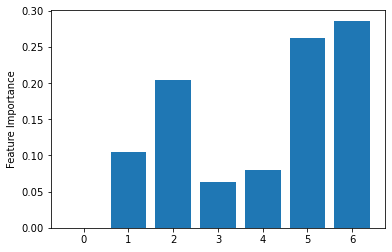

In [93]:
# Feature Importance
importance = tree_clf.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.ylabel('Feature Importance')
plt.bar([x for x in range(len(importance))], importance)
plt.show()


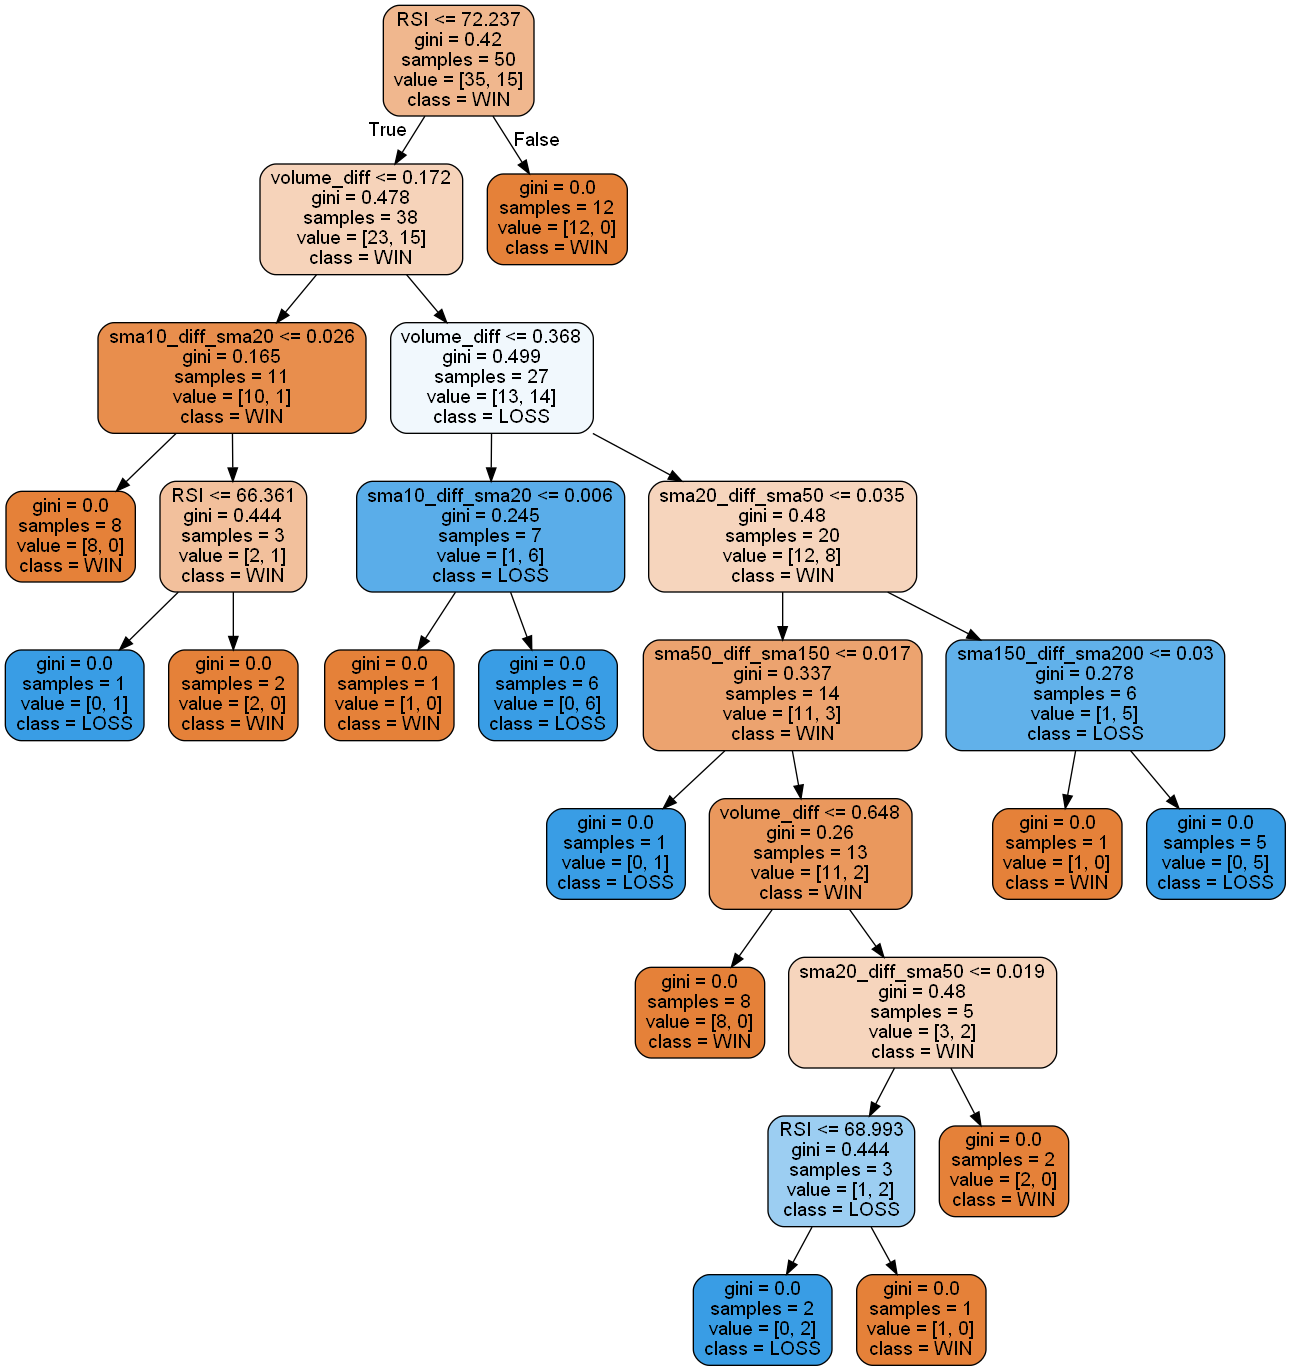

In [94]:
Dot_Image = export_graphviz(
    tree_clf,
    out_file = None,
    feature_names = feature_list,
    class_names = class_list,
    rounded = True,
    filled = True
)

graph = graph_from_dot_data(Dot_Image) 
graph.write_png('Decision_tree_output.png') 

Image(filename='Decision_tree_output.png', width=1024) 


## To evaluate the performance of the classification model

In [95]:
y_predict=tree_clf.predict(X_test)
pd.crosstab(y_test,y_predict,rownames=["Actual class"],colnames=["Predicted class"])

Predicted class  False  True
Actual class                
False                3     6
True                 3     1

In [96]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

       False       0.50      0.33      0.40         9
        True       0.14      0.25      0.18         4

    accuracy                           0.31        13
   macro avg       0.32      0.29      0.29        13
weighted avg       0.39      0.31      0.33        13

